In [1]:
from utils.utils import load_checkpoint, plot
from utils.dataset import *
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
model_path = Path('D:\\Jonathan\\2-Projects\\syde770-project\\outputs\\lstm\\2023-08-23_224126')

In [3]:
valid_files_path = Path("D:\\Jonathan\\3-Datasets\\syde770_processed_data\\subjects_2023-07-12")
train_files, val_files, test_files = get_file_lists(
    val_sub_list=['05', 10, 15, 20, 25, 30],
    test_sub_list=[10], # 
    valid_files_path=valid_files_path
)

BATCH_SIZE = 16
test_dataset = SmartwatchDataset(test_files)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, collate_fn=SmartwatchAugmentTransformer(augment=False), drop_last=True, shuffle=False)

In [4]:
len(test_dataset), len(test_loader)

(18, 1)

In [5]:
from model.Transformer import TransformerModel

params = {
    "input_size": 9,
    'd_model': 32,
    'dropout': 0.06315639803617487,
    'downsample': False,
    "n_heads": 8,
    "stride": 2,
    "kernel_size": 15,
    "seq_len": 512,
    "downsample": False,
    "output_size": 7,
    "num_encoder_layers": 5,
    "num_decoder_layers": 5
}

model = TransformerModel(**params)

In [6]:
data = next(iter(test_loader))
data.keys()

dict_keys(['encoder_inputs', 'decoder_inputs', 'targets', 'encoder_padding_mask', 'decoder_padding_mask', 'decoder_lookahead_mask', 'encoder_lookahead_mask'])

In [7]:
device = "cuda"

model = model.to(device)
with torch.no_grad():
    encoder_inputs = data["encoder_inputs"].to(device)
    decoder_seed = data["decoder_inputs"][:, 0, :].unsqueeze(1).to(device)
    
    # Step 1
    output = model(encoder_inputs, decoder_seed) # output = [16, 512, 7]
    decoder_outputs = torch.cat([decoder_seed, output.unsqueeze(1)], dim=1)
    
    for i in range(1, 512):
        output = model(encoder_inputs, decoder_outputs)
        decoder_outputs = torch.cat([decoder_outputs, output[:, -1, :].unsqueeze(1)], dim=1)

In [10]:
data["decoder_inputs"][:, 0, :].unsqueeze(1).shape

torch.Size([16, 1, 7])

In [11]:
output[:, -1, :].unsqueeze(1).shape

torch.Size([16, 1, 7])

In [9]:
for b in range(BATCH_SIZE):
    plt.plot(decoder_outputs[b, :, :].cpu())
plt.show()

: 

: 

In [45]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation

def plot_line(ax, coords, c='k', **kwargs):
    ax.plot(coords[:, 0], coords[:, 1], zs=coords[:, 2], c=c, **kwargs)
    return ax

def plot_path_and_normal_vec(pos, quat, start=0, stop=100):
    """
    pos: (N, 3) array of positions
    quat: (N, 4) array of quaternion values
    """
    rot = Rotation.from_quat(quat).as_matrix()
    norm_vecs = -1 * rot[:, 0, :]  # Want negative x basis as the normal vec to smartwatch on wrist

    inds = slice(start, stop)

    xs = pos[inds, 0]
    ys = pos[inds, 1]
    zs = pos[inds, 2]

    # Plot position trajectory
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(xs, ys, zs=zs)

    # Plot normal vectors at each timepoint
    for i in range(*inds.indices(512)):
        origin = pos[i, :]
        delta = norm_vecs[i, :]
        ax = plot_line(ax, np.vstack([origin, origin + 0.1 * delta]), c='r', lw=0.5)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

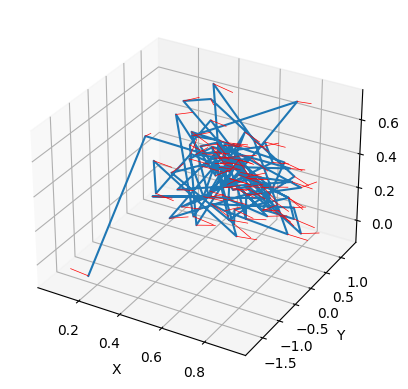

In [48]:
i = 0

pos = decoder_outputs[i, :, 0:3].cpu().numpy()  # Verify these indices are correct wrt dataloader
quat = decoder_outputs[i, :, 3:].cpu().numpy()

plot_path_and_normal_vec(pos, quat, start=0, stop=100)